<a href="https://colab.research.google.com/github/GeorgeM2000/IMDB-Reviews-Sentiment-Classification/blob/main/IMDB_Reviews_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import matplotlib and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Setup input pipeline

Download the dataset using TFDS. I have kept the initial ratio of training, validation, and testing data.

In [ ]:
train_dataset, validation_dataset, test_dataset = tfds.load(
    name="imdb_reviews",
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

The original value for the "VOCAB_SIZE" is 1000. I have increased that value because a larger vocabulary size would allow the model to capture a more extensive range of words in the dataset. Also, the size of the vocabulary would affect the capacity of the embedding layer because a larger vocabulary size increases the number of parameters in the embedding layer.

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 8000 # Original: 1000, Model 1: 10000, Model 2: 5000

Next shuffle the data for training and create batches of these (text, label) pairs:

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

# Create the text encoder

In [ ]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

# Model Creation


The original model, which i have modified, included the following architecture:

- The encoder: the encoder is responsible for converting raw text into a numerical format that the neural network can process
- An embedding layer: this layer helps the model learn meaningful representations for words
- A bidirectional LSTM layer: LSTM layers process the input sequence (word embeddings) in both forward and backward directions
- Two dense layers: these layers produce the output of the model, representing the probability of a review being positive or negative
   
In addition to the original architecture, i have added the following layers:

- A GlobalMaxPooling1D Layer: this layer is added after the bidirectional LSTM layer to capture the most important features from the output sequence of the LSTM.
- A Dropout layer: this layer helps prevent overfitting
- A Dense layer with the sigmoid function: the sigmoid function is commonly used for binary classification models

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Instead of the Adam optimizer, the RMSprop optimizer is chosen due to its adaptive learning rate, stability features that prevent vanishing gradients, and efficient convergence properties.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(1e-3),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          512000    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         66048     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                        

The EarlyStopping callback is important when the model fails to demonstrate performance improvement over a specified number of epochs (in our case its three epochs). In such instances, the execution halts, ensuring that the best weights are retained, preventing unnecessary computational expense.

In [ ]:
# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Stop training when validation loss does not improve
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

Epoch 1/10
235/235 [==============================] - 64s 197ms/step - loss: 0.6292 - accuracy: 0.6210 - val_loss: 0.4173 - val_accuracy: 0.8301
Epoch 2/10
235/235 [==============================] - 31s 132ms/step - loss: 0.3747 - accuracy: 0.8417 - val_loss: 0.4981 - val_accuracy: 0.7945
Epoch 3/10
235/235 [==============================] - 37s 156ms/step - loss: 0.2684 - accuracy: 0.8959 - val_loss: 0.2902 - val_accuracy: 0.8812
Epoch 4/10
235/235 [==============================] - 31s 131ms/step - loss: 0.2241 - accuracy: 0.9155 - val_loss: 0.2780 - val_accuracy: 0.8856
Epoch 5/10
235/235 [==============================] - 27s 111ms/step - loss: 0.1841 - accuracy: 0.9333 - val_loss: 0.3291 - val_accuracy: 0.8652
Epoch 6/10
235/235 [==============================] - 32s 135ms/step - loss: 0.1583 - accuracy: 0.9432 - val_loss: 0.3007 - val_accuracy: 0.8848
Epoch 7/10
235/235 [==============================] - 25s 104ms/step - loss: 0.1352 - accuracy: 0.9545 - val_loss: 0.3421 - val_ac

As we can see, the execution terminates at epoch 7 due to the model's decreasing performance over the past three epochs. Therefore, the model considers the results from epoch 4. Compared to the original model's results, we have the following:

- **The model's performance on the testing set has been improved, thus reducing the validation and testing loss**
- **The accuracy on both the training and validation set has also been improved and**
- **The training process requires less epochs to achieve a better performace**



In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.2872 - accuracy: 0.8809
Test Loss: 0.2872490882873535
Test Accuracy: 0.8808799982070923


(0.0, 0.6538766130805016)

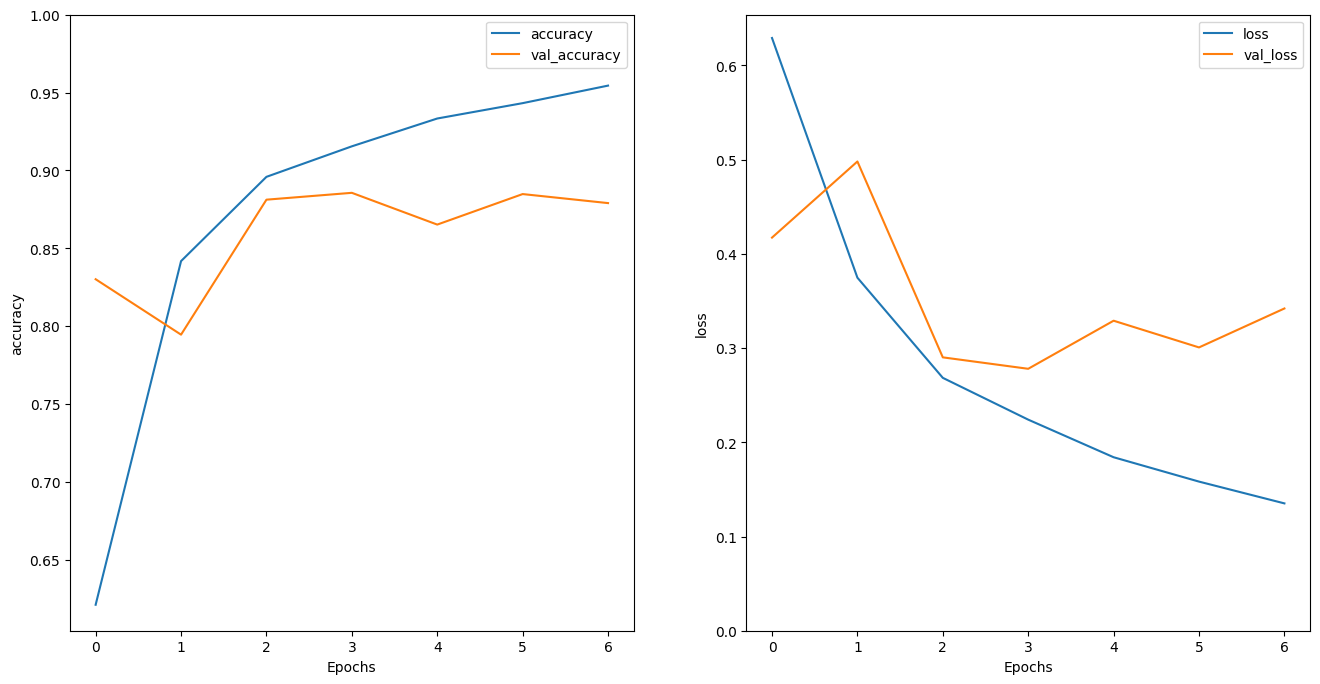

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


In [ ]:
sample_text = ('The movie was awful. I did not manage to see all of it.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 20ms/step
[[0.03723971]]
